In [45]:
import numpy as np
from scipy.integrate import odeint
import scipy.stats
import matplotlib.pyplot as plt
import copy

In [46]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)

# import the function we want from that file
from plot_utility import plot_tme

# Nominal trajectory, measurements

In [47]:
class MonoCamera:
    def __init__(self):
        self.std = 0.1
        self.v = scipy.stats.norm(0, self.std)
        
    def control(self, X, t):
        #g_des = (np.sin(0.05*t)+1)**4*np.sin(0.5*t)
        #g_des = np.sin(2*t)
        #g, d = X 
        #gain = 0.5
        u_g = 4*np.sin(2*t) #gain*(g_des-g)
        return u_g
    
    def f(self, X, t):
        g, d = X
        # control
        u_g = self.control(X, t)
        # dynamics
        g_dot = u_g # - 0.01*g
        d_dot = 0
        x_dot = [g_dot, d_dot]
        return x_dot
    
    # g = ground speed
    # d = distance
    def h(self, X, t):
        g, d = X
        u_g = self.control(X, t)
        y = np.array([g/d + self.v.rvs(g.shape), 
                      g + self.v.rvs(g.shape), 
                      d + self.v.rvs(d.shape),
                      2*g + self.v.rvs(g.shape),
                      2*d + self.v.rvs(g.shape),])
        return y
    
    def simulate(self, x0, tsim):
        result = odeint(self.f, x0, tsim)
        X = result.T
        U = np.atleast_2d(self.control(X, tsim))
        Y = self.h(X, tsim)
        return X, U, Y

In [48]:
sys = MonoCamera()

x0 = np.array([5, 3]) # initial conditions
tsim = np.arange(0, 30, 0.01) # simulation  time

X, U, Y = sys.simulate(x0, tsim)

In [49]:
print(X.shape)
print(Y.shape)
print(U.shape)

(2, 3000)
(5, 3000)
(1, 3000)


(0.0, 30.0)

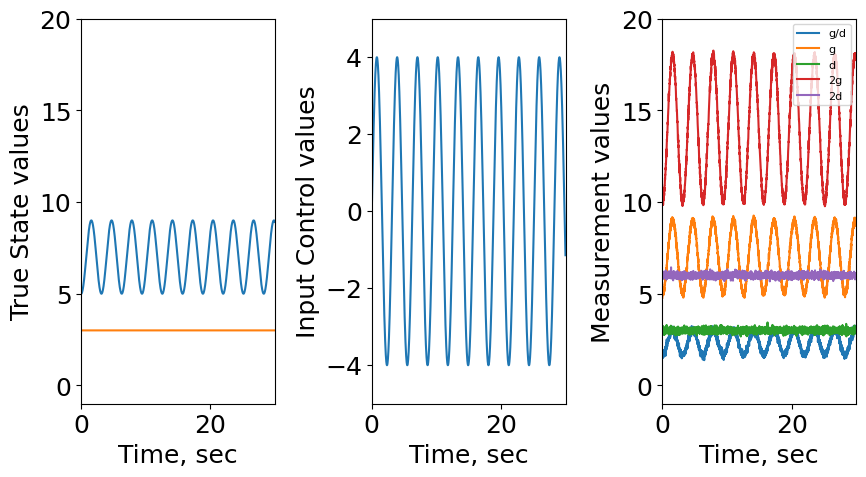

In [50]:
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(wspace=0.5)

# States
ax = fig.add_subplot(131)

ax.plot(tsim, X[0,:])
ax.plot(tsim, X[1,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('True State values')

ax.set_ylim([-1, 20])
ax.set_xlim([0, 30])

# Controls
ax = fig.add_subplot(132)

ax.plot(tsim, U[0,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('Input Control values')

ax.set_ylim([-5, 5])
ax.set_xlim([0, 30])

# Measurements
ax = fig.add_subplot(133)

ax.plot(tsim, Y[0,:], label='g/d')
ax.plot(tsim, Y[1,:], label='g')
ax.plot(tsim, Y[2,:], label='d')
ax.plot(tsim, Y[3,:], label='2g')
ax.plot(tsim, Y[4,:], label='2d')
#ax.plot(tsim, Y[1,:])

# legend on the right
ax.legend(loc='upper right', fontsize=8)

ax.set_xlabel('Time, sec')
ax.set_ylabel('Measurement values')
ax.set_ylim([-1, 20])
ax.set_xlim([0, 30])

# Initial conditions

In [51]:
# Initial conditions
x0 = np.array([[5], [2.5]])
P0 = 1000000*np.eye(2)

# Noise defined by measurement noise
R = sys.std**2*np.eye(5)

# Fairly accurate model
Q = 5e-4*np.eye(2)

# Extended Kalman Filter

Note: this EKF function expects everything to be given as 2D arrays. 

In [52]:
#!pip install git+https://github.com/florisvb/pyEKF.git

In [53]:
import ekf

In [54]:
def f_d(X, U):
    dt=0.01
    g, d = np.ravel(X)
    u, = np.ravel(U)
    g_dot = u # 0.01*g
    d_dot = 0
    x_new = np.atleast_2d(np.array([g + g_dot*dt, d + d_dot*dt])).T
    return x_new

def h_d(X, U):
    dt=0.01
    g, d = np.ravel(X)
    u, = np.ravel(U)
    sensors = [np.array( [g/d] ), np.array(g), np.array(d), np.array(2*g), np.array(2*d)]
    y = np.atleast_2d(np.hstack(sensors)).T
    return y

In [55]:
xhat, P, s = ekf.ekf(Y, x0, f_d, h_d, Q, R, U)

<Axes: xlabel='Time', ylabel='x1'>

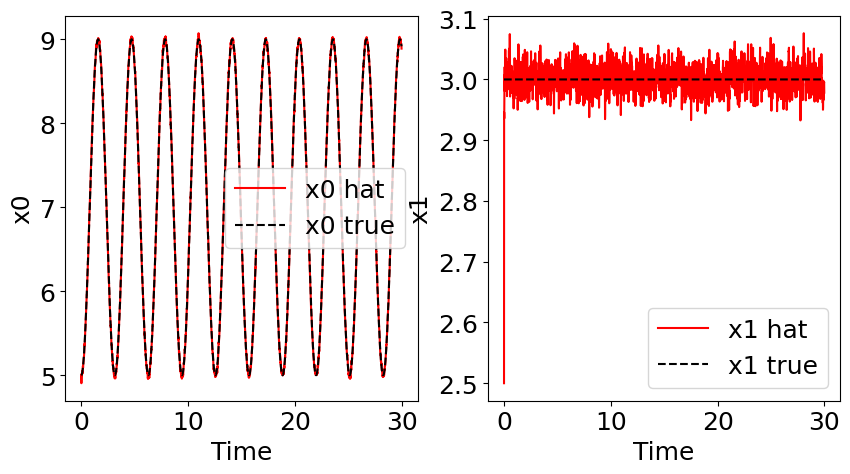

In [56]:
fig = plt.figure(figsize=(10,5))


ax = fig.add_subplot(121)
plot_tme(tsim, X[0,:].T, None, xhat[0,:].T, ax=ax, label_var='x0')

ax = fig.add_subplot(122)
plot_tme(tsim, X[1,:].T, None, xhat[1,:].T, ax=ax, label_var='x1')

# Cramer Rao Bound

### numerical jacobian

Maybe could be more efficient using ``jax``?

In [57]:
def jacobian(f, x0, u0, epsilon=0.001):
    
    # Get A
    Aj = []
    for i in range(len(f(x0,u0))):
        
        def f_scalar(x,u,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]
        
        j = scipy.optimize.approx_fprime(x0, f_scalar, epsilon, u0, i)
        Aj.append(j)
        
    # Get B
    Bj = []
    for i in range(len(f(x0,u0))):
        
        def f_scalar(u,x,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]
        
        j = scipy.optimize.approx_fprime(u0, f_scalar, epsilon, x0, i)
        Bj.append(j)
    
    return np.matrix(np.vstack(Aj)), np.matrix(np.vstack(Bj))

### cramer rao bound

In [58]:
inv = np.linalg.inv

invJk_diags = []
Jk = inv(P0)
for i in range(len(tsim)):
    xhat_i = xhat[:,i]
    u_i = U[:,i]
    
    A, B = jacobian(f_d, np.ravel(xhat_i), np.ravel(u_i))
    C, D = jacobian(h_d, np.ravel(xhat_i), np.ravel(u_i))
    
    Jk = inv(Q) - inv(Q)@A@inv(Jk + A.T@inv(Q)@A)@A.T@inv(Q) + C.T@inv(R)@C
    
    invJk_diags.append(np.diag( inv(Jk)) )

In [59]:
CRB = np.vstack(invJk_diags).T

### show CRB

Red dashed lines are 3-sigma bounds determined by the KF.
Gray shading is the 3-sigma CRB bound. 

(-3.0, 6.0)

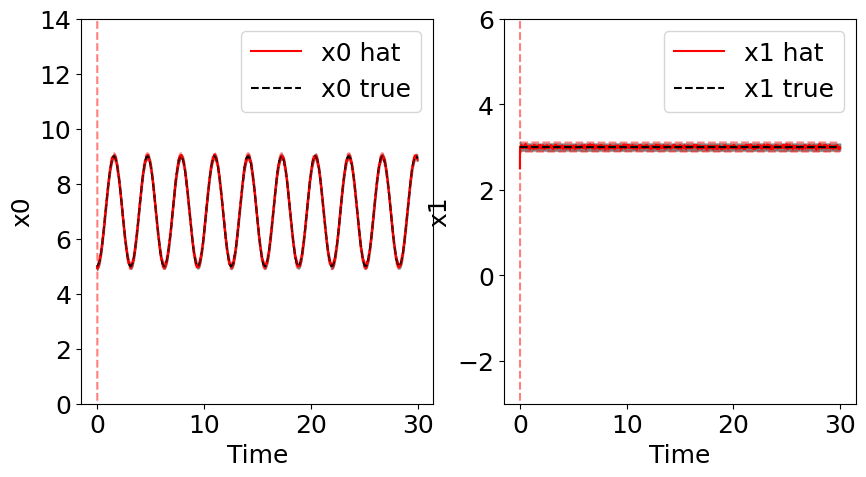

In [60]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(121)
plot_tme(tsim, X[0,:].T, None, xhat[0,:].T, ax=ax, label_var='x0')
ax.plot(tsim, 3*P[0,0,:]**0.5+X[0,:].T, '--', color='red', alpha=0.5)
ax.plot(tsim, -3*P[0,0,:]**0.5+X[0,:].T, '--', color='red', alpha=0.5)
ax.fill_between(tsim, X[0,:].T+3*CRB[0,:]**0.5, X[0,:].T-3*CRB[0,:]**0.5, color='gray', zorder=-100)
ax.set_ylim(0, 14)


ax = fig.add_subplot(122)
plot_tme(tsim, X[1,:].T, None, xhat[1,:].T, ax=ax, label_var='x1')
ax.plot(tsim, 3*P[1,1,:]**0.5+X[1,:].T, '--', color='red', alpha=0.5)
ax.plot(tsim, -3*P[1,1,:]**0.5+X[1,:].T, '--', color='red', alpha=0.5)
ax.fill_between(tsim, X[1,:].T+3*CRB[1,:]**0.5, X[1,:].T-3*CRB[1,:]**0.5, color='gray', zorder=-100)
ax.set_ylim(-3,6)

# Unscented Kalman Filter

Note: this UKF function expects everything to be given as 2D matrices

In [61]:
#!pip install git+https://github.com/florisvb/pyUKFsqrt.git

In [62]:
import ukf_sqrt

ModuleNotFoundError: No module named 'ukf_sqrt'

In [ ]:
def f_d(X, U, w=0):
    dt=0.01
    g = X[0,0]
    d = X[1,0]
    g_dot = U[0,0] #- 0.01*g
    d_dot = 0
    x_new = np.matrix([g + g_dot*dt, d + d_dot*dt]).T + w
    return x_new

def h_d(X, U, v=0):
    g = X[0,0]
    d = X[1,0]
    y = np.matrix( [g/d] ).T + v
    return y

In [ ]:
xhat, P, s = ukf_sqrt.ukf_sqrt(np.matrix(Y), np.matrix(x0), 
                               f_d, h_d, 
                               np.matrix(Q), 
                               np.matrix(R), 
                               np.matrix(U), None)

(-3.0, 6.0)

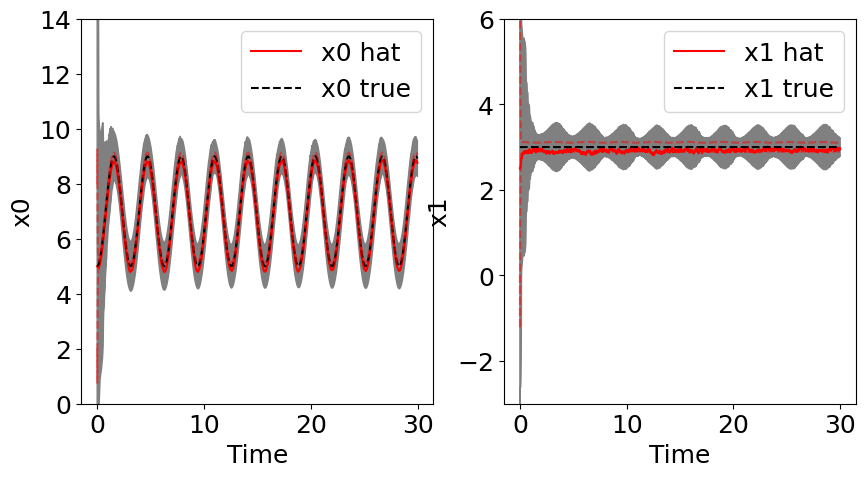

In [ ]:
fig = plt.figure(figsize=(10,5))


ax = fig.add_subplot(121)
plot_tme(tsim, X[0,:].T, None, xhat[0,:].T, ax=ax, label_var='x0')
ax.plot(tsim, 3*P[0,0,:]**0.5+X[0,:].T, '--', color='red', alpha=0.5)
ax.plot(tsim, -3*P[0,0,:]**0.5+X[0,:].T, '--', color='red', alpha=0.5)
ax.fill_between(tsim, X[0,:].T+3*CRB[0,:]**0.5, X[0,:].T-3*CRB[0,:]**0.5, color='gray', zorder=-100)
ax.set_ylim([0, 14])


ax = fig.add_subplot(122)
plot_tme(tsim, X[1,:].T, None, xhat[1,:].T, ax=ax, label_var='x1')
ax.plot(tsim, 3*P[1,1,:]**0.5+X[1,:].T, '--', color='red', alpha=0.5)
ax.plot(tsim, -3*P[1,1,:]**0.5+X[1,:].T, '--', color='red', alpha=0.5)
ax.fill_between(tsim, X[1,:].T+3*CRB[1,:]**0.5, X[1,:].T-3*CRB[1,:]**0.5, color='gray', zorder=-100)
ax.set_ylim([-3,6])

# Exercises

1. Try a less observable trajectory, do the estimates get worse?
2. Take the planar drone example from earlier, and replace the GPS sensor with this "optic flow" sensor, then run an EKF and UKF on that system